# 🗺️ UNav Mapping Pipeline Visualization

This notebook provides visualization and quality assessment tools for the mapping pipeline of the UNav system.

- **Purpose:** Inspect and analyze the outputs of each mapping stage: SLAM reconstruction, perspective slicing, feature extraction, feature matching, and triangulation.
- **Usage:** Use this notebook to verify that the generated maps, feature files, and COLMAP results are correct and of sufficient quality before proceeding to localization and navigation.
- **Typical Workflow:**  
    1. Load SLAM and COLMAP reconstructions  
    2. Visualize perspective image slices and extracted features  
    3. Inspect pairwise feature matches and inlier verification  
    4. Validate 3D triangulated structures

---

_Note: This notebook is meant for debugging, QA, and method development, not for real-time system use._


## 1. Set Up Paths and Global Configuration

Define all root directories, map identifiers (place, building, floor), and feature models. This ensures all subsequent operations are reproducible and easy to adapt for different datasets or buildings.

In [1]:
DATA_TEMP_ROOT = '/mnt/data/UNav-IO/temp'
DATA_FINAL_ROOT = '/mnt/data/UNav-IO/data'

PLACEHOLDER = 'New_York_University'
BUILDING = 'Langone'
FLOOR = '17_floor'

FEATURE_MODEL = 'DinoV2Salad'

## 2. Import Dependencies and Visualization Tools

Import all required Python modules and custom visualization utilities. These tools enable both geometric and appearance-based inspection of mapping outputs.

In [2]:
import os
import h5py
from unav.visualization_tools.mapping_visualization_tools import (
    visualize_point_cloud_views,
    plot_camera_trajectory_xz,
    visualize_random_matches,
    show_sample_images_with_pose,
    visualize_local_keypoints,
    render_colmap_point_cloud_views
)
from unav.config import UNavConfig

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 3. Build UNav Mapping Configuration

Create a unified mapping configuration object that manages paths, models, and all mapping parameters. This object is passed throughout the pipeline to standardize I/O and settings.

In [3]:
config = UNavConfig(
    data_temp_root=DATA_TEMP_ROOT,
    data_final_root=DATA_FINAL_ROOT,
    mapping_place=PLACEHOLDER,
    mapping_building=BUILDING,
    mapping_floor=FLOOR,
    global_descriptor_model=FEATURE_MODEL
)
config = config.mapping_config

[✓] YAML written to: /mnt/data/UNav-IO/temp/equirectangular.yaml.


## 4. Visualize Raw SLAM Point Cloud

Render the raw point cloud generated by dense visual SLAM (`stella_vslam_dense`). This helps verify SLAM coverage, structural integrity, and major failure modes such as drift or outlier noise.

[INFO] Points before filtering: 2495806, after: 2495806 (100.0%)


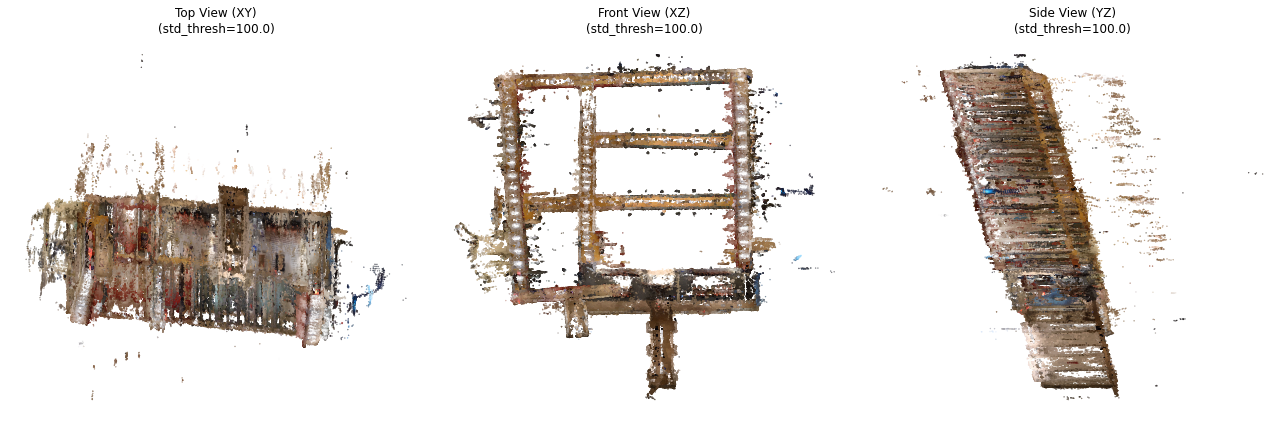

In [4]:
pc_path = os.path.join(
    config.data_temp_root,
    config.place,
    config.building,
    config.floor,
    "stella_vslam_dense",
    "output_cloud.ply"
)

# View the SLAM-generated point cloud from different angles
visualize_point_cloud_views(pc_path, std_threshold=100.0)

## 5. Plot Camera Trajectory in XZ Plane

Display the camera keyframe trajectory projected onto the XZ plane (horizontal slice). This is useful for evaluating trajectory smoothness, loop closures, and alignment with building geometry.

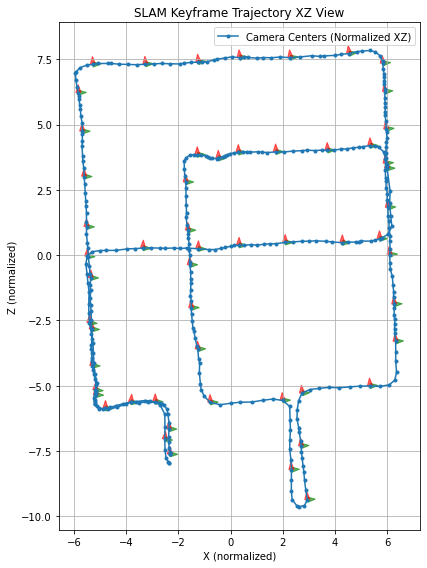

In [5]:
plot_camera_trajectory_xz(
    config.slicer_config["trajectory_file"],
    title="SLAM Keyframe Trajectory XZ View",
    show_axis=True,
)

## 6. Show Sample Perspective Images and Their Camera Poses

Randomly sample and display several perspective images along with their estimated camera poses. This enables a qualitative check that pose annotation is correctly aligned with image appearance.

[INFO] Total images found with pose: 7020


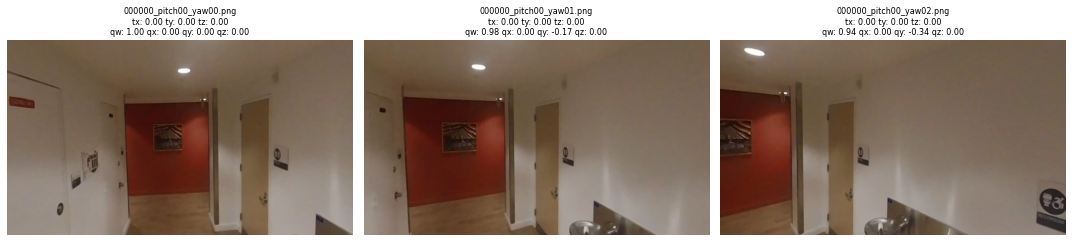

In [6]:
show_sample_images_with_pose(
    image_dir=config.slicer_config["output_perspective_dir"],
    image_file=config.colmap_config["image_file"],
    num_images=3
)

## 7. Inspect Global Descriptor Features (HDF5)

Load and inspect statistics from the global descriptor HDF5 file. Check the total number of images, feature shapes, and distribution (mean/std). This step helps verify the completeness and correctness of global feature extraction.

In [7]:
global_feat_path = os.path.join(
    config.feature_extraction_config["output_feature_dir"],
    f"global_features_{config.feature_extraction_config['global_descriptor_model']}.h5"
)

print(f"[INFO] Checking global features: {global_feat_path}")
with h5py.File(global_feat_path, 'r') as h5_file:
    print(f"[INFO] Total images with global descriptor: {len(h5_file.keys())}")
    sample_img = list(h5_file.keys())[0]
    descriptor = h5_file[sample_img][:]
    print(f"[Sample Image] {sample_img}")
    print(f"[Descriptor Shape] {descriptor.shape}")
    print(f"[Descriptor Mean] {descriptor.mean():.4f}")
    print(f"[Descriptor Std] {descriptor.std():.4f}")

[INFO] Checking global features: /mnt/data/UNav-IO/data/New_York_University/Langone/17_floor/features/global_features_DinoV2Salad.h5
[INFO] Total images with global descriptor: 7020
[Sample Image] 000000_pitch00_yaw00.png
[Descriptor Shape] (8448,)
[Descriptor Mean] 0.0002
[Descriptor Std] 0.0109


## 8. Visualize Local Keypoints for a Sample Image

Display the local keypoints detected on a representative image. This is used to check the quality and density of keypoint detection, as well as the alignment with image content.

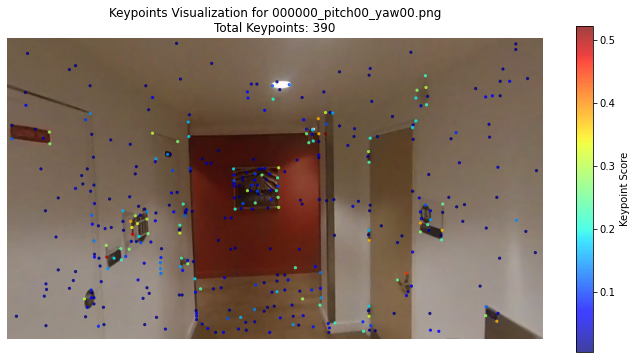

In [8]:
# Display detected local keypoints for the first sampled image
visualize_local_keypoints(
    img_name=sample_img,
    image_dir=config.feature_extraction_config["input_perspective_dir"],
    local_feature_file=config.feature_extraction_config['local_feat_save_path']
)

## 9. Visualize Random Feature Matches

Randomly select feature pairs and visualize their matches. This allows verification of the feature matching stage and can reveal problems such as mismatches, poor descriptor separation, or geometric inconsistency.

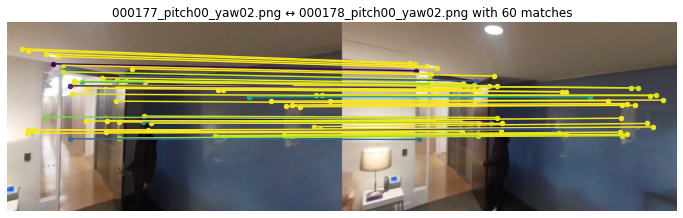

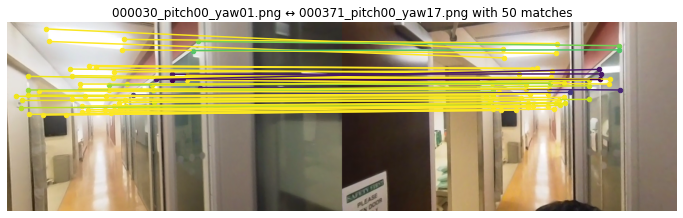

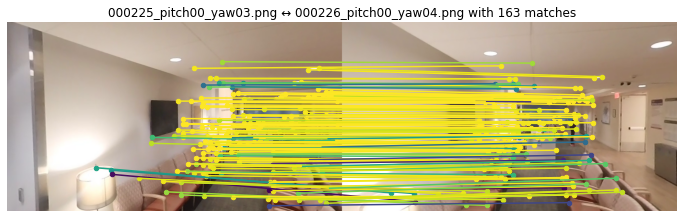

In [9]:
visualize_random_matches(
    local_feature_file=config.feature_extraction_config["local_feat_save_path"],
    matches_file=config.colmap_config["match_file"],
    image_dir=config.slicer_config["output_perspective_dir"],
    num_pairs=3,
    colormap='viridis'
)

## 10. Render 3D Point Cloud from COLMAP Triangulation

Visualize the final 3D point cloud generated after COLMAP triangulation with known poses. This output is critical for confirming the final 3D structure used for localization and navigation.

[INFO] Total images: 7020
[INFO] Total 3D points before filtering: 48918
[INFO] 3D points after outlier removal: 43845


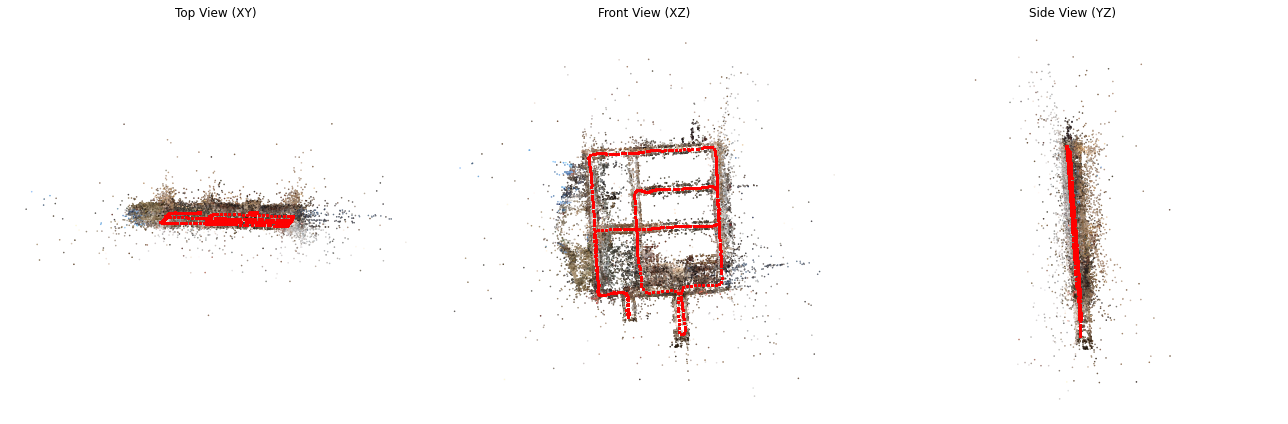

In [10]:
model_dir = os.path.join(
    config.data_final_root,
    config.place,
    config.building,
    config.floor,
    "colmap_map"
)

# Visualize the triangulated 3D structure from COLMAP
render_colmap_point_cloud_views(model_dir, ext=".bin")